# Game of Life

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 6

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

For the animations in this notebook to work, you might have to install
ffmpeg.  On Ubuntu and Linux Mint, the following should do it:

    sudo add-apt-repository ppa:mc3man/trusty-media
    sudo apt-get update
    sudo apt-get install ffmpeg
    
If you have instructions for other operating systems, please let me know and I will add them here.

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Game of Life entities

In [3]:
from Life import Life, LifeViewer

def make_viewer(n, m, row, col, *strings):
    """Makes a Life and LifeViewer object.
    
    n, m: rows and columns of the Life array
    row, col: upper left coordinate of the cells to be added
    strings: list of strings of '0' and '1'
    """
    life = Life(n, m)
    life.add_cells(row, col, *strings)
    viewer = LifeViewer(life)
    return viewer

A beehive is a stable entity, also called a "still life"

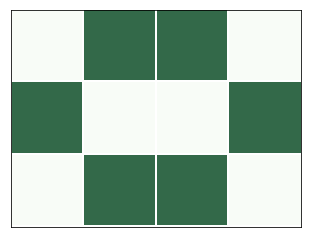

In [4]:
# beehive
viewer = make_viewer(3, 4, 0, 0, '0110', '1001', '0110')
viewer.draw(grid=True)
plt.savefig('chap06-1.pdf')

Here's what it looks like after one step:

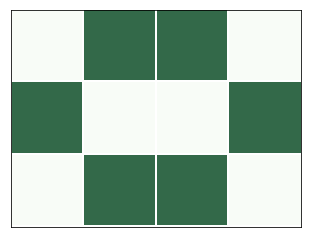

In [5]:
viewer.step()
viewer.draw(grid=True)

A toad is an oscillator with period 2.  Here's are its two configurations:

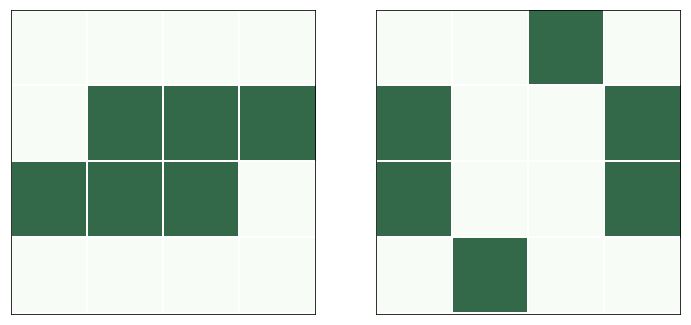

In [6]:
# toad
thinkplot.preplot(cols=2)
viewer = make_viewer(4, 4, 1, 0, '0111', '1110')
viewer.draw(grid=True)

thinkplot.subplot(2)
viewer.step()
viewer.draw(grid=True)

plt.savefig('chap06-2.pdf')

Here's what it looks like as an animation.

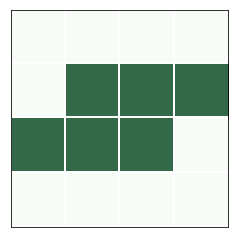

In [7]:
viewer.step()
anim = viewer.animate(frames=4, interval=500, grid=True)

If the following cell yields a RuntimeError with a message like "No MovieWriters available", you probably need to install ffmpeg.  See instructions at the top of this notebook.

In [8]:
anim

A glider is a spaceship that translates one unit down and to the right with period 4. 

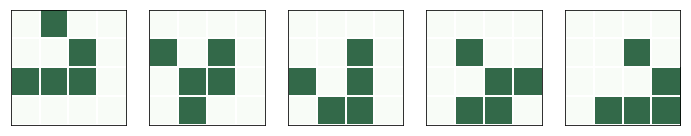

In [9]:
# glider
glider = ['010', '001', '111']

thinkplot.preplot(cols=5)
viewer = make_viewer(4, 4, 0, 0, *glider)
viewer.draw(grid=True)

for i in range(2, 6):
    viewer.step()
    thinkplot.subplot(i)
    viewer.draw(grid=True)
    
plt.savefig('chap06-3.pdf')

Here's an animation showing glider movement.

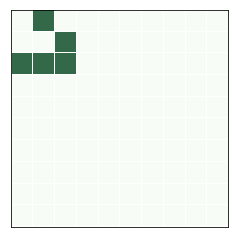

In [10]:
viewer = make_viewer(10, 10, 0, 0, '010', '001', '111')
anim = viewer.animate(frames=32, interval=200, grid=True)

In [11]:
anim

The r-pentomino starts with only five live cells, but it runs for 1103 steps before stabilizing.

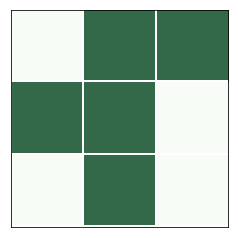

In [12]:
# r pentomino
rpent = ['011', '110', '010']

viewer = make_viewer(3, 3, 0, 0, *rpent)
viewer.draw(grid=True)

Here are the start and finish configurations.

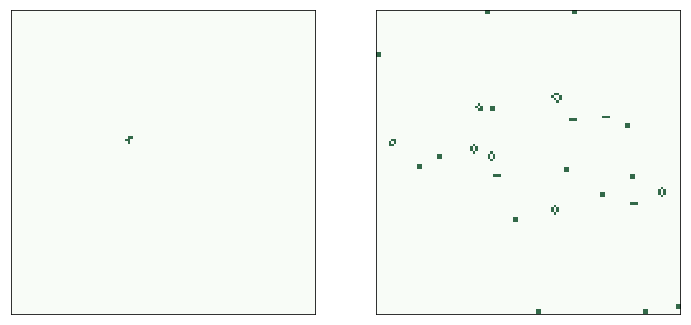

In [13]:
# r pentomino
rpent = ['011', '110', '010']

thinkplot.preplot(cols=2)
viewer = make_viewer(120, 120, 50, 45, *rpent)
viewer.draw()

for i in range(1103):
    viewer.step()

thinkplot.subplot(2)
viewer.draw()
plt.savefig('chap06-4.pdf')

And here's the animation that shows the steps.

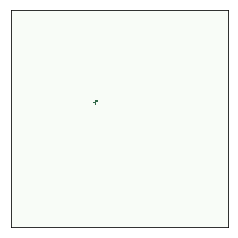

In [14]:
viewer = make_viewer(120, 120, 50, 45, *rpent)
anim = viewer.animate(frames=1200, interval=10)

In [15]:
anim

### Conway's conjecture

Most initial conditions run for a short time and reach a steady state.  Some, like the r-pentomino, run for a long time before they reach steady state.  Another example is [rabbits](https://web.archive.org/web/20081221152607/http://www.argentum.freeserve.co.uk/lex_r.htm#rabbits), which starts with only nine cells and runs 17331 steps before reaching steady state.

To run my implementation of rabbits, open a terminal in `ThinkComplexity2/code` and run

```
python LifeRabbits.py
```

Patterns that take a long time to reach steady state are called [Methuselahs](https://en.wikipedia.org/wiki/Methuselah_(cellular_automaton))

Patterns like these prompted Conway's conjecture, which asks whether there are any initial conditions where the number of live cells is unbounded.

Gosper's glider gun was the first entity to be discovered that produces an unbounded number of live cells, which refutes Conway's conjecture.

In [16]:
glider_gun = [
    '000000000000000000000000100000000000',
    '000000000000000000000010100000000000',
    '000000000000110000001100000000000011',
    '000000000001000100001100000000000011',
    '110000000010000010001100000000000000',
    '110000000010001011000010100000000000',
    '000000000010000010000000100000000000',
    '000000000001000100000000000000000000',
    '000000000000110000000000000000000000'
]

Here's the initial configuration:

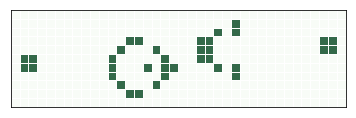

In [17]:
viewer = make_viewer(11, 38, 1, 1, *glider_gun)
viewer.draw(grid=True)
plt.savefig('chap06-5.pdf')

And here's what it looks like running:

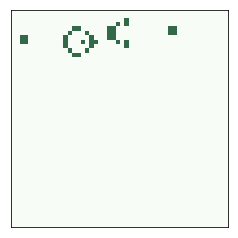

In [18]:
viewer = make_viewer(50, 50, 2, 2, *glider_gun)
anim = viewer.animate(frames=500, interval=20)

In [19]:
anim

### Implementing Game of Life

As an example, I'll start with an array of random cells:

In [20]:
a = np.random.randint(2, size=(10, 10)).astype(np.uint8)
print(a)

[[1 1 1 0 0 1 0 1 0 1]
 [0 1 0 0 1 1 0 1 1 0]
 [0 0 1 1 0 1 0 1 1 1]
 [0 1 0 1 1 1 0 1 1 0]
 [0 0 0 0 1 1 0 1 0 1]
 [0 1 0 1 0 1 1 0 1 1]
 [1 1 0 1 0 1 1 0 0 0]
 [1 0 1 0 0 0 0 1 1 0]
 [0 0 1 1 1 1 1 1 1 0]
 [1 0 1 1 1 0 1 1 1 0]]


The following is a straightforward translation of the GoL rules using `for` loops and array slicing.

In [21]:
b = np.zeros_like(a)
rows, cols = a.shape
for i in range(1, rows-1):
    for j in range(1, cols-1):
        state = a[i, j]
        neighbors = a[i-1:i+2, j-1:j+2]
        k = np.sum(neighbors) - state
        if state:
            if k==2 or k==3:
                b[i, j] = 1
        else:
            if k == 3:
                b[i, j] = 1

print(b)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 1 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


Here's a smaller, faster version using cross correlation.

In [22]:
from scipy.signal import correlate2d

kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])

c = correlate2d(a, kernel, mode='same')
b = (c==3) | (c==2) & a
b = b.astype(np.uint8)
print(b)

[[1 1 1 0 1 1 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 0 1 0 0 0 0 1 1]
 [1 0 0 1 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 1 0]]


Using a kernel that gives a weight of 10 to the center cell, we can simplify the logic a little.

In [23]:
kernel = np.array([[1, 1, 1],
                   [1,10, 1],
                   [1, 1, 1]])

c = correlate2d(a, kernel, mode='same')
b = (c==3) | (c==12) | (c==13)
b = b.astype(np.uint8)
print(b)

[[1 1 1 0 1 1 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 0 1 0 0 0 0 1 1]
 [1 0 0 1 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 1 0]]


More importantly, the second version of the kernel makes it possible to use a look up table to get the next state, which is faster and even more concise.

In [24]:
table = np.zeros(20, dtype=np.uint8)
table[[3, 12, 13]] = 1
c = correlate2d(a, kernel, mode='same')
b = table[c]
print(b)

[[1 1 1 0 1 1 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 0 1 0 0 0 0 1 1]
 [1 0 0 1 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 1 0]]


**Exercise:**  Start GoL in a random state and run it until it stabilizes.
What stable patterns can you identify?

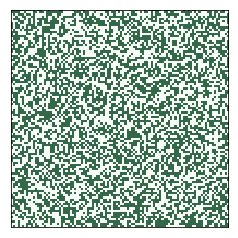

In [25]:
# Solution

# Most random starting configurations yield lots of blinkers, blocks, 
# and beehives, with a few ships, boats, and loaves.

# See Achim Flammenkamp, "Most seen natural occurring ash objects in Game of Life",
# http://wwwhomes.uni-bielefeld.de/achim/freq_top_life.html)

n, m = 100, 100
life = Life(n, m)
life.array = np.random.randint(2, size=(n, m)).astype(np.uint8)
viewer = LifeViewer(life)
anim = viewer.animate(frames=1000, interval=20)

In [26]:
# Solution

anim

**Exercise:** Many Game of Life patterns are available in portable file formats.  For one source, see http://www.conwaylife.com/wiki/Main_Page.

Write a function to parse one of these formats and initialize the array.

In [27]:
# Solution

# The easiest format to parse is plain text: 
        
def read_life_file(life, filename, row, col):
    i = row
    with open(filename) as f:
        for line in f:
            if line.startswith('!'):
                continue
            line = line.strip()
            line = line.replace('O', '1')
            line = line.replace('.', '0')
            life.add_cells(i, col, line)
            i += 1

In [28]:
# Solution

# Here's an example that loads a period 52 oscillator.

n = 19
m = 19
row = 1
col = 1

life = Life(n, m)
filename = '35p52.cells.txt'
read_life_file(life, filename, row, col)

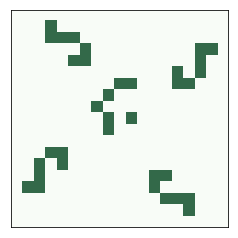

In [29]:
# Solution

# And here's the animation

viewer = LifeViewer(life)
anim = viewer.animate(frames=52, interval=100)

In [30]:
# Solution

anim

**Exercise:** One of the longest-lived small patterns is ``rabbits'', which starts with
9 live cells and takes 17 331 steps to stabilize.  You can get the initial configuration in various formats from http://www.conwaylife.com/wiki/Rabbits.  Load this configuration
and run it.

In [31]:
# Solution

# My solution to this exercise is in `LifeRabbits.py`.

**Exercise:** In my implementation, the `Life` class is based on a parent class
called `Cell2D`, and `LifeViewer` is based on `Cell2DViewer`.  You can
use these base classes to implement other 2-D cellular automatons.

For example, one variation of GoL, called ``Highlife'', has the
same rules as GoL, plus one additional rule: a dead cell with 6
neighbors comes to life.

Write a class named `Highlife` that inherits from `Cell2D` and implements
this version of the rules.  Also write a class named `HighlifeViewer`
that inherits from `Cell2DViewer` and try different ways
to visualize the results.  As a simple example, use a different
color map.

One of the more interesting patterns in Highlife is the replicator.
Use `add_cells` to initialize Highlife with a replicator and see what it
does.

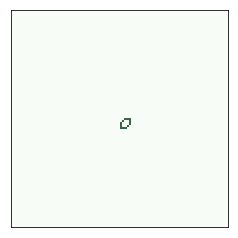

In [32]:
# Starter code

from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d

class MyLife(Cell2D):
    """Implementation of Life."""
    kernel = np.array([[1, 1, 1],
                       [1,10, 1],
                       [1, 1, 1]])

    table = np.zeros(20, dtype=np.uint8)
    table[[3, 12, 13]] = 1

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array = self.table[c]
        

class MyLifeViewer(Cell2DViewer):
    """Viewer for Highlife."""
    cmap = plt.get_cmap('Greens')
    
replicator = [
    '00111',
    '01001',
    '10001',
    '10010',
    '11100'
]

n = 100
life = MyLife(n)
life.add_cells(n//2, n//2, *replicator)
viewer = MyLifeViewer(life)
anim = viewer.animate(frames=200)

In [33]:
# Starter code

anim

In [34]:
# Solution

class Highlife(Cell2D):
    """Implementation of Highlife."""
    kernel = np.array([[1, 1, 1],
                       [1,10, 1],
                       [1, 1, 1]])

    table = np.zeros(20, dtype=np.uint8)
    table[[3, 6, 12, 13]] = 1

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array = self.table[c]
        

class HighlifeViewer(Cell2DViewer):
    """Viewer for Highlife."""
    cmap = plt.get_cmap('Purples')

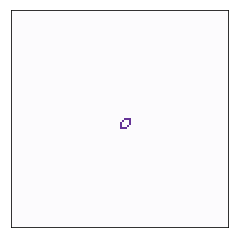

In [35]:
# Solution

replicator = [
    '00111',
    '01001',
    '10001',
    '10010',
    '11100'
]

n = 100
life = Highlife(n)
life.add_cells(n//2, n//2, *replicator)
viewer = HighlifeViewer(life)
anim = viewer.animate(frames=200)

In [36]:
# Solution

anim

**Exercise:** 

If you generalize the Turing machine to two dimensions, or
add a read-write head to a 2-D CA, the result is a
cellular automaton called a Turmite.  It is named after a
termite because of the way the read-write head moves, but
spelled wrong as an homage to Alan Turing.

The most famous Turmite is Langton's Ant, discovered by Chris Langton
in 1986.  See http://en.wikipedia.org/wiki/Langton_ant.

The ant is a read-write head with
four states, which you can think of as facing north, south,
east or west.  The cells have two states, black and white.

The rules are simple.  During each time step, the ant checks the color
of the cell it is on.  If black, the ant turns to the right,
changes the cell to white, and moves forward one space.  If the cell
is white, the ant turns left, changes the cell to black, and moves
forward.

Given a simple world, a simple set of rules, and only one moving part,
you might expect to see simple behavior---but you should know
better by now.  Starting with all white cells, Langton's ant
moves in a seemingly random pattern for more than 10 000 steps
before it enters a cycle with a period of 104 steps.  After
each cycle, the ant is translated diagonally, so it leaves
a trail called the "highway".

Write an implementation of Langton's Ant.

In [37]:
# Solution
    
# My solution to this exercise is in `Turmite.py`.
    
from Turmite import Turmite, TurmiteViewer

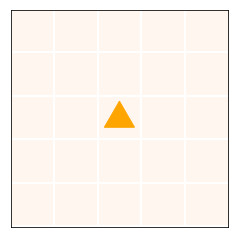

In [38]:
# Solution

# Here's a small version that shows the first 20 steps:

n = 5
turmite = Turmite(n)
viewer = TurmiteViewer(turmite)
anim = viewer.animate(frames=20, interval=500, grid=True)

In [39]:
# Solution

anim

In [40]:
# Solution

# To see the rest, run `python Turmite.py` in a terminal, running for 10700 steps.
